In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function
from sympy.matrices import Matrix
import sympy as sp
from TCSPC import *

In [2]:
NADH = Simulation([0.75,0.25],[0.4,4])

### DEMO

#### Brief Introduction to Simulation class object:

Input: <ul>
       <li>amp - an array of amplitudes/fractional intensity of mono-exponential components</li>
       <li>tau - an array of lifetimes of mono-exponential components</li>
       <li>IRF characteristics e.g. offset, irfwidth, bg, run_time can be modified,
       but have default values as in the given script</li>
       <li>Histogram properties, e.g. window - x-axis range, n_bins - number of bins</li>
       </ul>
Methods: 

* `multi_exp_data` generate 1 multi exponential curve (1d array of size n_bins)\
* `MC_exp` : generate an array of mono exponential decay curves or 1 multi exponential curve using Monte Carlo method (i.e. random number generator, drawing from normal (IRF) and exponential distribution (decay))
* `plot`   : Plot the generated data. Need to pass a matplotlib `ax` object for plotting.\
Select data simulation function by setting MC =True (`MC_exp`) or False (`multi_exp_data`)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


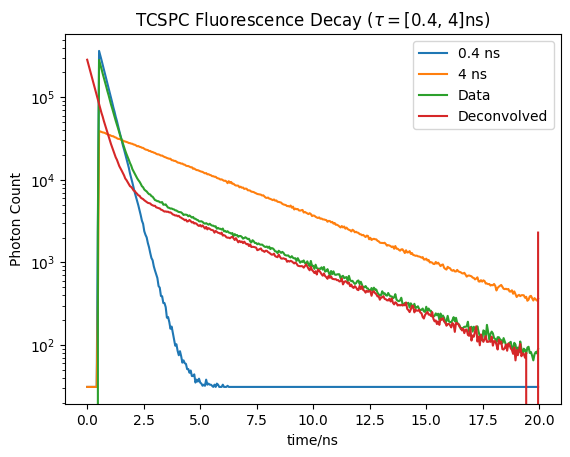

In [8]:
t, y_NADH = NADH.MC_exp()
fig,ax = plt.subplots(1,1)
NADH.plot(ax) #plot mono exp component
NADH.plot(ax,multi=True) #plot multi exp 
NADH.plot(ax,multi=True,deconv=True) #plot data deconvolved with IRF
handles, labels = ax.get_legend_handles_labels()
labels[-1] = 'Deconvolved'
ax.legend(labels)

In [7]:
handles, labels = ax.get_legend_handles_labels()
labels

['0.4 ns', '4 ns', 'Data', 'Data']